In [460]:
%load_ext dotenv
%dotenv ../../src/.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [461]:
import sys
sys.path.append("../../src")

In [462]:
from utils.logger import get_logger
_logs = get_logger(__name__)

In [463]:
import os
from glob import glob

In [464]:
import random

data_files = glob(os.path.join(os.getenv('SRC_DIR'), "processed/*.csv"))

In [465]:
data_files

['../../data/processed\\01_ticker_features.csv',
 '../../data/processed\\02_time_series_dataset.csv',
 '../../data/processed\\03_clustered_dataset.csv']

In [466]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns  
import joblib

- **Load data**

In [467]:
df=pd.read_csv(data_files[0])

In [468]:
df.shape

(447, 327)

In [469]:
# Keep ticker separately
id_col = "ticker"

In [470]:
# Make a copy to avoid modifying original
data = df.copy()

In [471]:
id_col = "ticker"

cat_cols = []
numeric_cols = []

for col in data.columns:
    if col == id_col:
        continue
    if pd.api.types.is_numeric_dtype(data[col]):
        numeric_cols.append(col)
    else:
        cat_cols.append(col)


- **Preprocessing pipelines**

In [472]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [473]:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [474]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, cat_cols)
])

- **Helper scorer for clustering**

In [475]:
# Simple silhouette scorer for GridSearchCV (unsupervised)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)

    # If only one cluster found, silhouette can't be computed
    if len(set(labels)) < 2:
        return -1.0

    return silhouette_score(X, labels)


In [476]:
# Calinski-Harabasz score helper
def ch_score(X, labels):
    # CH score can't be computed if there's only one cluster
    if len(set(labels)) < 2:
        return -1.0
    return calinski_harabasz_score(X, labels)


In [477]:
data.shape

(447, 327)

- **Manual K-Mean clustering without grid search**

In [478]:
# Drop id column
X = data.drop(columns=[id_col])

best_score = -1
best_params = None

In [479]:
for n_comp in [12, 18, 24, 30]:       # PCA choices
    for n_clusters in [3, 4, 5, 6, 8, 10]:  # cluster choices
        # Preprocess + PCA
        X_pca = PCA(n_components=n_comp).fit_transform(preprocessor.fit_transform(X))
        
        # KMeans clustering
        labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(X_pca)
        
        # Silhouette score
        sil = silhouette_score(X_pca, labels)
        
        if sil > best_score:
            best_score = sil
            best_params = {'pca__n_components': n_comp, 'cluster__n_clusters': n_clusters}


In [480]:
print("Best silhouette:", best_score)
print("Best params:", best_params)

Best silhouette: 0.8042239582252567
Best params: {'pca__n_components': 12, 'cluster__n_clusters': 3}


In [481]:
X_pca = PCA(n_components=12).fit_transform(preprocessor.fit_transform(data))
labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_pca)
data['cluster'] = labels

In [482]:
cluster_summary = data.groupby('cluster')[numeric_cols].mean()
print(cluster_summary)

         accounts payable_1  accounts payable_2  accounts payable_3  \
cluster                                                               
0              2.916412e+09        3.045275e+09        3.081977e+09   
1              2.940890e+10        3.020390e+10        3.043840e+10   
2              1.193750e+11        1.125740e+11        1.226698e+11   

         accounts payable_4  accounts receivable_1  accounts receivable_2  \
cluster                                                                     
0              2.331159e+09          -4.100942e+07          -7.733146e+07   
1              2.165596e+10          -1.247900e+09          -1.379500e+09   
2              1.127528e+11           5.062500e+08          -5.882500e+08   

         accounts receivable_3  accounts receivable_4  \
cluster                                                 
0                -6.016402e+07           1.769355e+07   
1                -6.669000e+08           4.482600e+08   
2                -1.002250e+09

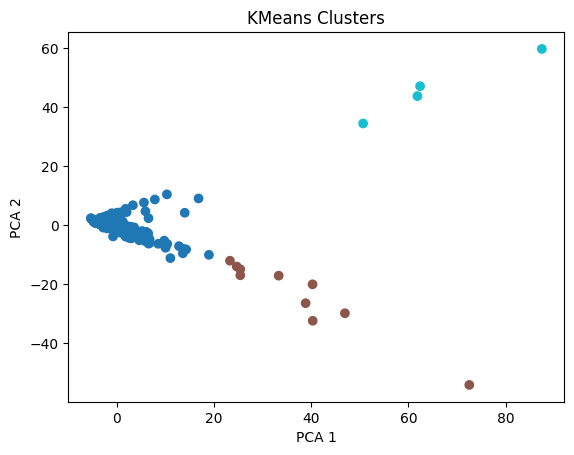

In [483]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters")
plt.show()

In [484]:
data['cluster'].value_counts()


cluster
0    433
1     10
2      4
Name: count, dtype: int64

In [485]:
PROCESSED_DIR = os.path.join(os.getenv('SRC_DIR', '.'), "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [486]:
clustered_data_path = os.path.join(PROCESSED_DIR, "03_clustered_dataset.csv")

In [487]:
data[['ticker', 'cluster']].to_csv(clustered_data_path, index=False)
print(f"Clustered dataset saved to: {clustered_data_path}")

Clustered dataset saved to: ../../data/processed\03_clustered_dataset.csv
